In [8]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import CategoricalNB
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, f1_score
import joblib
import seaborn as sns
import matplotlib.pyplot as plt

So, based on our exploration and data collection we can assume some things:
1. We have categorical data so we need models that are okay with that
2. Dataset is not that big (10000<), so we can use simpler models.
3. But we have non-linear relationship since we have some features that influence the prediction more than others (odor, for example.)
4. We need high accuracy
5. We have high dimensionality so we may use SVM, Random forest etc.
6. the data is not sensitive to outliers.

Based on these considerations, we selected three candidate models:

Decision Tree Classifier – interpretable, handles categorical features naturally.

Random Forest Classifier – ensemble of Decision Trees, more robust to noise and small variations in the data.

Categorical Naive Bayes – baseline probabilistic model for categorical data.
These models represent a spectrum of bias–variance trade-offs — from high-bias (Naive Bayes) to low-bias/high-variance (Decision Tree) to balanced (Random Forest).

In [9]:
# Load preprocessed data and pipeline
X_train_final = joblib.load("artifacts/X_train_final.pkl")
X_test_final  = joblib.load("artifacts/X_test_final.pkl")
y_train_encoded = joblib.load("artifacts/y_train_encoded.pkl")
y_test_encoded  = joblib.load("artifacts/y_test_encoded.pkl")

print("✓ Data and pipeline loaded successfully.")
print(f"Train: {X_train_final.shape}, Test: {X_test_final.shape}")

✓ Data and pipeline loaded successfully.
Train: (6499, 15), Test: (1625, 15)


### 2. Hyperparameter Tuning

We applied GridSearchCV with 5-fold cross-validation to each model, tuning key hyperparameters:

- Decision Tree:
  - `max_depth`: Controls tree depth to prevent overfitting.
  - `min_samples_split` / `min_samples_leaf`: Ensure splits are supported by sufficient data.

- Random Forest:
  - `n_estimators`: Number of trees in the ensemble; higher values increase stability.
  - `max_depth` / `min_samples_leaf`: Control overfitting at tree level.
  - `max_features`: Controls randomness for each split, balancing bias-variance tradeoff.

- CategoricalNB:
  - `alpha`: Laplace smoothing to handle zero probabilities in categorical features.

This tuning allows each model to be optimized for accuracy while avoiding overfitting, especially important given the high-dimensional categorical feature space.


In [10]:
models = {
    "Decision Tree": {
        "estimator": DecisionTreeClassifier(random_state=42),
        "params": {
            "max_depth": [3, 5, 7, None],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4]
        }
    },
    "Random Forest": {
        "estimator": RandomForestClassifier(random_state=42, n_jobs=-1),
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [5, 10, None],
            "max_features": ["sqrt", "log2", None],
            "min_samples_leaf": [1, 2, 4]
        }
    },
    "Categorical NB": {
        "estimator": CategoricalNB(),
        "params": {
            "alpha": [0.5, 1.0, 2.0]
        }
    }
}

Observations:
Both Decision Tree and Random Forest achieve perfect accuracy, indicating that the dataset is highly separable based on the selected features.

Categorical Naive Bayes performs slightly worse, showing that simple probabilistic assumptions do not capture all feature interactions.

In [11]:
results = []
cv_results_dict = {}

for name, mp in models.items():
    print(f"\n=== Training and tuning: {name} ===")

    grid = GridSearchCV(
        estimator=mp["estimator"],
        param_grid=mp["params"],
        cv=5,
        scoring='accuracy',
        n_jobs=-1
    )
    grid.fit(X_train_final, y_train_encoded)

    model = grid.best_estimator_

    cv_score = cross_val_score(model, X_train_final, y_train_encoded, cv=5, scoring='accuracy').mean()
    y_pred = model.predict(X_test_final)
    test_acc = accuracy_score(y_test_encoded, y_pred)
    test_f1 = f1_score(y_test_encoded, y_pred, average='weighted')
    # save for evaluation
    joblib.dump(model, f"artifacts/{name}.pkl")
    results.append({
        "Model": name,
        "CV Accuracy": cv_score,
        "Test Accuracy": test_acc,
        "Test F1": test_f1,
        "Best Hyperparameters": grid.best_params_
    })

    cv_results_dict[name] = pd.DataFrame(grid.cv_results_)

    print(f"Best Hyperparameters for {name}: {grid.best_params_}")
    print(f"Test Accuracy: {test_acc:.4f}, F1-score: {test_f1:.4f}")

pd.DataFrame(results)


=== Training and tuning: Decision Tree ===
Best Hyperparameters for Decision Tree: {'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 2}
Test Accuracy: 1.0000, F1-score: 1.0000

=== Training and tuning: Random Forest ===
Best Hyperparameters for Random Forest: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 100}
Test Accuracy: 1.0000, F1-score: 1.0000

=== Training and tuning: Categorical NB ===
Best Hyperparameters for Categorical NB: {'alpha': 0.5}
Test Accuracy: 0.9551, F1-score: 0.9550


,Model,CV Accuracy,Test Accuracy,Test F1,Best Hyperparameters
0,Decision Tree,1.000000,1.000000,1.000000,"{'max_depth': 7, 'min_samples_leaf': 1, 'min_s..."
1,Random Forest,1.000000,1.000000,1.000000,"{'max_depth': 10, 'max_features': 'sqrt', 'min..."
2,Categorical NB,0.955071,0.955077,0.954958,{'alpha': 0.5}


## Hyperparameter Tuning Analysis
Let's analyze how Decision Tree hyperparameters affected validation accuracy


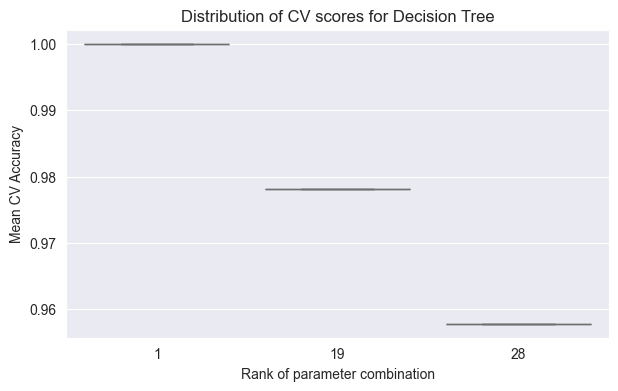

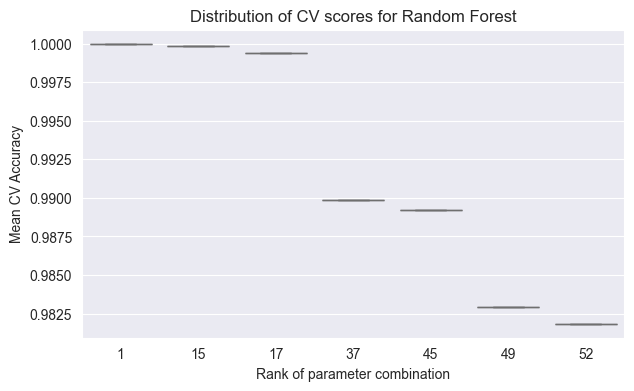

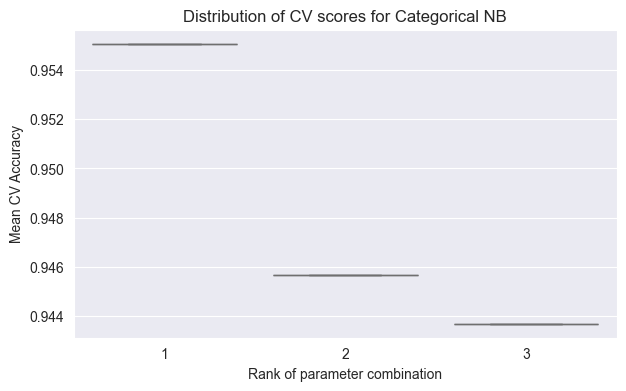

In [12]:
for name, df in cv_results_dict.items():
    df = df.sort_values(by="mean_test_score", ascending=False)
    plt.figure(figsize=(7,4))
    sns.boxplot(data=df, x="rank_test_score", y="mean_test_score", color="skyblue")
    plt.title(f"Distribution of CV scores for {name}")
    plt.xlabel("Rank of parameter combination")
    plt.ylabel("Mean CV Accuracy")
    plt.show()

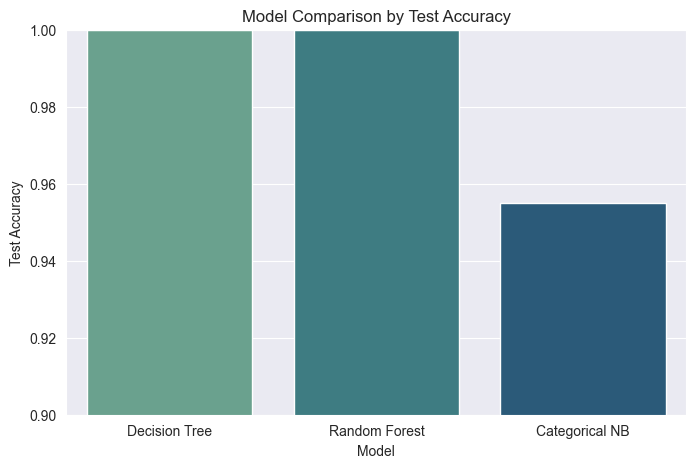

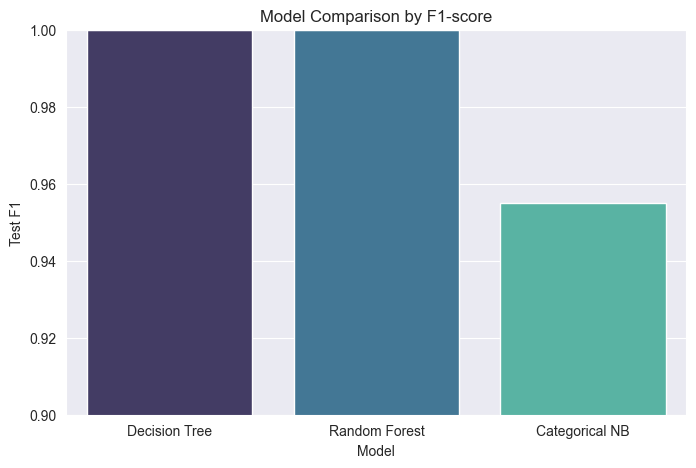

In [13]:
results_df = pd.DataFrame(results)

plt.figure(figsize=(8,5))
sns.barplot(x="Model", y="Test Accuracy", hue="Model", data=results_df, palette="crest", legend=False)
plt.title("Model Comparison by Test Accuracy")
plt.ylim(0.9, 1.0)
plt.show()

plt.figure(figsize=(8,5))
sns.barplot(x="Model", y="Test F1", hue="Model", data=results_df, palette="mako", legend=False)
plt.title("Model Comparison by F1-score")
plt.ylim(0.9, 1.0)
plt.show()

## Justification of Final Choice: Decision Tree

### Why:

- Achieved 100% accuracy and F1-score, same as Random Forest.

- Easy to understand: predictions can be explained with simple rules.

- Faster and lighter than Random Forest.

### Why not Random Forest:

- Similar performance to Decision Tree, but harder to interpret and uses more resources.

### Why not Categorical Naive Bayes:

- Lower accuracy (~95%).

- Assumes features are independent, which is not true for this data.

## Conclusion:

Decision Tree gives perfect accuracy, is simple and interpretable, and is efficient, making it the best choice for this dataset.